In [11]:
%matplotlib notebook
from IPython.display import Image
from matplotlib import pyplot
import numpy

# Lab 5 - Array Signal Processing

In this lab we'll explore concepts in array signal processing. When we have an array of transmitters or receivers we're able to control properties of our signal across space. We'll first explore angle-of-arrival (AoA) estimation, where we can detect where in space a certain signal is coming from. Then we'll explore beamforming, which is a way of increasing the signal gain (either the transmitted or received signal gain) at a certain point in space. Finally we'll quickly touch on spatial multiplexing, which is the most effective way to boost capacity for links with high SNR.

## Part 1: Estimating the AoA of the incoming signal

Angle of arrival (AoA) measurement is a method for determining the direction of propagation of a radio-frequency wave incident on an antenna array. AoA determines the direction by measuring the path length difference at individual elements of the array -- from these difference the AoA can be calculated.

## 1.1: AoA estimation principle

We first use a single-path case to illustrate the basic idea of AoA estimation. Suppose there are two antennas on the access point, the spacing between these two antennas is $\frac{\lambda}{2}$ (where $\lambda$ is the wavelength). The wireless signal impinges these two antennas with an angle $\theta$. The key to estiamtion the wireless signals' angle of arrival is to analyze the phase of the received signal at these two antennas. 

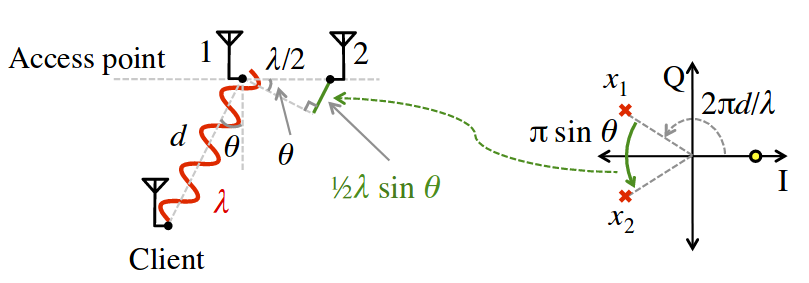

In [12]:
Image(filename='aoa_estimation.png', width=500)

As shown, the path difference can be simply computed as $\frac{\lambda}{2}sin(\theta)$. Let $x_1$ and $x_2$ be the received signal at antenna 1 and antenna 2, seperately. Then the AoA $\theta$ can be simply estimated as: $\arcsin(\frac{\angle x_2 - \angle x_1}{\pi})$.



### Generalizing to multiple antennas

While in indoor places, due to the multi-path effect, the wireless signal will impinge the antenna array from multiple angles. Here we will introduce how to use multiple antennas to estimate multiple AoAs.


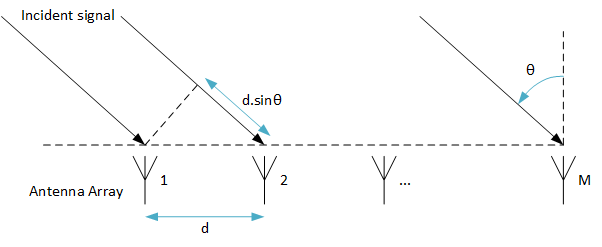

In [13]:
Image(filename='M_antennaArray.png', width=500)

Suppose the Access point has $M$ antennas, $D<M$ wirelee signals $s_1,s_2,...,s_D$ impinge the antenna array from $D$ different angles $\theta_1,\theta_2,...,\theta_D$. The received signal at each antenna is inherently the superposition of these $D$ signals. Denoting the received signal at $j^{th}$ antenna as $x_j$. We use $\textbf{steering vector}$ $a(\theta)$ to characterize how much added phase (relatve to the first antenna) we see at each antenna:

\begin{equation}
a(\theta) = \left[ 
\begin{matrix}
1\\ 
exp(-j\pi sin\theta)\\ 
exp(-j2\pi sin\theta)\\ 
...\\ 
exp(-j(M-1)\pi sin\theta)
\end{matrix}
 \right ]
\end{equation}

The received signal $\textbf{x}=[x_1,x_2,...,x_D]^{T}$ can be expressed as:

\begin{equation}
\mathbf{x} = \mathbf{A}\mathbf{s}+\mathbf{n}=[a(\theta_1),a(\theta_2),...,a(\theta_D)]\left [ \begin{matrix}
s_1\\ 
s_2\\ 
...\\ 
s_D
\end{matrix} \right ] + \mathbf{n}
\end{equation}

where $\mathbf{n}$ is the noise. The correlation matrix of the received signals $\mathbf{R_{xx}}$ can be written as:

\begin{equation}
\mathbf{R_{xx}} = \mathbb{E}[\mathbf{xx^{*}}] = \mathbb{E}[(\textbf{As}+\textbf{n})(\mathbf{s^{*}A^{*}}+\mathbf{n^{*}})]
=\mathbf{A}\mathbb{E}[\mathbf{ss^{*}}]\mathbf{A^{*}} + \mathbb{E}[\mathbf{nn^{*}}]
=\mathbf{AR_{ss}}\mathbf{A^{*}} + \sigma ^2\mathbf{I}
\end{equation}

where $\mathbf{R_{ss}}$ is the source correlation. The array correlation matrix has $M$ eigenvalues associated respectively with $M$ eigenvectors $\mathbf{E}=[E_1,E_2,...,E_M]$. Usually the noise is smaller than the signal, so if we sort the eigenvalue in a non-decreasing order, the smallest $M-D$ eigenvalues should correspond to the noise, while other $D$ eigenvalues correspond to the $D$ incoming signals.

The likelihood of the signal that impinge the antenna array with a signal $\theta$ can be calculated as:

\begin{equation}
P(\theta) =\frac{1}{\mathbf{a(\theta)^{*}E_NE_N^{*}a(\theta)}} = \frac{1}{\mathbf{||E_{N}^{*}a(\theta)||^2}}
\end{equation}

By inputing the angle from $-90^{\circ}$ to $90^{\circ}$, we will get a pseudo spectrum, where the x-axis is the angle and y-axis is the likelihood. We are expected to get $D$ peaks on this pseudo spetrum.

### Problem 1: Implementing MUSIC (MUltiple SIgnal Classification) algrithm (40 point)
In this section, you are required to implement the MUSIC algorithm to estimate the AoA of the incoming signals. The receiver is assumed to have $M$ antennas.


#### Input:

1:  $\textbf{recv_signal}$: an 1xM array. $i^{th}$ entry is the phase reading on $i^{th}$ antenna.

2:  $\textbf{D}$: the number of multipath.

3:  $\textbf{M}$: the array size.

#### Output:

$\textbf{p_spectrum}$: an 1xN array shows the pseudo spectrum achieved by MUSIC algorithm. 

The basic steps of MUSIC algorithm are listed below:

1. Compute the correlation matrix of the received signal.
2. Compute the eigenvalues and the eigenvectors of the correlation matrix.
3. Extract the eigenvectors correspond to the noises.
4. Define the steering vector.
5. Loop over the input angle [-90,90], and compute the pseudo spectrum.



In [14]:
import numpy as np

def MUSIC_algo (recv_signal, D, M):

    # the wavelength of the wireless signal
    C = 3e8
    CHANNEL_FREQ = 2.442e9
    LAMBDA = C/CHANNEL_FREQ
    
    # antenna spacing: half lambda
    ANT_SPACING = LAMBDA/2
    

    # 1. compute the correlation matrix of the received signal.
    # the expected output matrix should be a [MxM] matrix
    # your code (5 point)
    # write three test cases to validate their correlation matrix is correct
    # check the photo for test case
    cor_matrix = np.matmul(recv_signal, recv_signal.getH())
    print(cor_matrix.shape)
    
    # 2. Compute the eigenvalues and the eigenvectors of the correlation matrix. 
    # You can use the numpy API to get the eigenvectors and eigenvalues: numpy.linalg.eig(input).
    # your code (5 point)
    
    eig_value, eig_vector = np.linalg.eig(cor_matrix)
    
    # 3. sorting the eigenvalues and eigenvectors, extracting the eigenvectors correspond to the noises.
    # your code (10 point)
    
    sor_dic = {}
    for i in range(len(eig_value)):
        sor_dic[eig_value[i]]=eig_vector[i]
    
    import collections
    od = collections.OrderedDict(sorted(sor_dic.items()))
    
    noisy_vector = []
    num = 0
    for key in od.keys():
        noisy.append(od[key])
        num = num + 1
        if num > M-D:
            break
    
        
    
    # 4. Define the steering vector (referring to the defination of a(theta)). 
    # The spacing between adjacent antennas is LAMBDA/2.
    # your code (5 point)
    
    
    def steering(theta):
        a_theta = numpy.zeros(M)
    
        for i in range(M):
            a_theta[i] = np.exp(complex(0, -1*np.pi*sin(theta)))
        return a_theta
    
    
    # 5. loop over the angle from -90 to 90 degrees in one degree increments, and compute the pseudo spectrum.
    # your code (5 point)
    
    p_spectrum = numpy.zeros(181)
    
    for i in range(-90, 90):
        p_spectrum[i] = 1.0/(np.conjugate(steering(i))*noisy*np.conjugate(noisy)*steering(i))
        print(p_spectrum[i])
    
    return p_spectrum

#### Testing: (5 point)

Please call the following three testing cases and compare the result with the groundtruth give below.
    

In [15]:
# Testing case 1, arrival angle: [0.1 0.3 0.7]*pi;
import scipy.io
mat = scipy.io.loadmat('AoA_estimation_data_01.mat')
recv_signal = mat['csi_sample']
D = 3
M = 8
p_spectrum = MUSIC_algo(recv_signal,D,M)
pyplot.figure()
pyplot.title("Pseudospectrum Estimate via MUSIC algorithm")
pyplot.plot(np.linspace(-90, 90, 181), np.abs(p_spectrum), 'blue')
pyplot.show()

# Testing case 2, arrival angle: 0.3*pi, 0.7*pi
mat = scipy.io.loadmat('AoA_estimation_data_02.mat')
recv_signal = mat['csi_sample']
D = 2
M = 10
p_spectrum = MUSIC_algo(recv_signal,D,M)
pyplot.figure()
pyplot.title("Pseudospectrum Estimate via MUSIC algorithm")
pyplot.plot(np.linspace(-90, 90, 181), np.abs(p_spectrum), 'blue')
pyplot.show()

AttributeError: 'numpy.ndarray' object has no attribute 'getH'

## Part 2 - Beamforming

Beamforming is a way of utilizing constructive interference to increase the signal gain at a certain point in space.

First we'll look into calculating the signal strength as a function of spatial location for a given transmitter array. This will give us an idea of how a given array distributes the signal in space. This is called an antenna's *beam pattern*.

In this lab we will deal only with one-dimensional arrays in a two-dimensional space. The beam pattern for a one-dimensional array in free-space is symmetric around the axis of the array. In other words, there is only one degree of freedom for the beam pattern; the angle from the axis of the array. Hopefully this should become clear as we explore one-dimensional arrays. You may want to think about what the symmetry would be for the beam patterns of two and three-dimensional arrays in free space.

### Problem 2.1 (10 pts) - Calculating Beam Patterns

- Fill in the function below to calculate what the signal gain would be at different points in space. (7 pts)
- Use the provided plotting code to plot the beam pattern. (1 pt)
- Increase the number of antennas and plot the beam pattern. How does the number of antennas seem to affect the beam pattern? (1 pt)
- Increase the spacing between the antennas and plot the beam pattern. How does the antenna spacing seem to affect the beam pattern? (1pt)

In [ ]:
def calculate_gains(tx_positions, rx_positions):
    """
    Returns an array of complex values for each of the rx_positions.
    The distances are in units of wavelength.
    """
    return numpy.zeros(len(rx_positions))

In [ ]:
def create_grid(*args):
    grid = numpy.array(numpy.meshgrid(*args))
    return grid.reshape((len(grid), -1)).T

tx_positions = numpy.array([[0.5 * x, 0] for x in numpy.arange(-3, 3)])
rx_xs = numpy.linspace(-10, 10, 100)
rx_ys = numpy.linspace(-10, 10, 100)
rx_positions = create_grid(rx_xs, rx_ys)
rx_signals = calculate_gains(tx_positions, rx_positions)

#pyplot.figure()
#pyplot.scatter(*rx_positions.T, c=abs(rx_signals))
#pyplot.scatter(*tx_positions.T, c='red')
#pyplot.show()

To control the beam pattern for a given antenna configuration we can control the phase added to the signal at each antenna. The simplest form of control is called *beam steering*. You should have seen that, for a linear array, the area of highest signal gain formed a beam perpendicular to the axis of the antenna array. With beam steering, we can control the angle of that beam relative to the axis of the antenna array.

### Problem 2.2 (10 pts) - Beam steering

- Implement the function `beam_steering_vector` below. This function should return the complex weights for each of the antennas in a uniform linear array to obtain a given beam angle. (4 pts)
- Modify your function `calculate_gains` to calculate the signal gain in space taking into account the complex weight for each antenna. (4 pts)
- Plot the beam pattern for an angle of $0.3 \pi$ radians. (2 pts)

In [ ]:
def beam_steering_vector(num_antennas, antenna_spacing, theta):
    """
    Returns an array of length `num_antennas` with values in radians.
    `theta` is in radians and is relative to the axis of the antennas.
    """
    return numpy.ones(num_antennas)

In [ ]:
def calculate_gains(tx_positions, rx_positions, tx_weights=None):
    if tx_weights is None:
        tx_weights = numpy.ones(len(tx_positions))
    return numpy.zeros(len(rx_positions))

In [ ]:
tx_positions = numpy.array([[0.5 * x, 0] for x in numpy.arange(-3, 3)])
steering_vector = beam_steering_vector(len(tx_positions), 0.5, 0.3 * numpy.pi)
rx_signals = calculate_gains(tx_positions, rx_positions, steering_vector)

pyplot.figure()
pyplot.scatter(*rx_positions.T, c=abs(rx_signals))
pyplot.scatter(*tx_positions.T, c='red')
pyplot.show()

We'll want to consider the spatial distribution of our signal not just in free space but also in an environment. In this case we can measure the channel `h` from the transmitter array to the point of reception. `h` is an array of complex values representing each transmit antenna's component. To maximize the signal gain at a certain point in space, we can set the steering vector to be the conjugate of `h`.

Suppose the transmitter has $M$ antennas, the receiver has one antenna to receive the signal. Let $x$ be the signal to be sent to the receiver and y be the received signal at the receiver antenna. Then we have:

\begin{equation}
\mathbf{y} = \mathbf{h}\mathbf{x}+\mathbf{n}=[h_1,h_2,...,h_m]\left [ \begin{matrix}
x\\ 
x\\ 
...\\ 
x
\end{matrix} \right ] + \mathbf{n}
\end{equation}

where $h_i$ is the channel state information of the channel between Tx$_i$ and the Rx. In order to make the signal constructively combined at the receiver, the transmitted signal $\mathbf{\bar{x}}$ should be set to:

\begin{equation}
\mathbf{\bar{x}} = [\bar{x_1}, \bar{x_2}, ..., \bar{x_M}]=\frac{1}{\sqrt{|h_1|^2+|h_2|^2+...+|h_m|^2}}\cdot \left [ \begin{matrix}
h_1^{*}\\ 
h_2^{*}\\ 
...\\ 
h_M^{*}
\end{matrix} \right ] \cdot x 
\end{equation}

where $\bar{x_i}$ is the new signal to be transmitted from the antenna $i$. $h_i^{*}$ is the conjugate of $h_i$.

To calculate the channel, we'll need to know our environment. We'll model our environment as a small number of point reflectors. The wireless signal propagates from each transmitter to the receiver through multiple paths. If there are $R$ reflectors, then there will be $M (R + 1)$ paths to consider; the path from each transmitter to the receiver through each reflector, and then the direct path from each transmitter directly to the receiver. The channel at the receiver is then simply the sum of all paths:

\begin{equation}
H_{i} = \sum_{l=1}^{L} \alpha_l \cdot \cdot e^{j\theta_l} = \sum_{l=1}^{L} \frac{1}{d_l^2} \cdot e^{j\theta_l} 
\end{equation}

where $\alpha_l$, $d_l$, and $\theta_l$ are the amplitude and phase of the signal propagates along $l^{th}$ path. $d_l$ is the path length.

### Problem 2.3 (15 pts) - Beamforming with reflections
- Implement the function `calculate_channel` below. (10 pts)
- Set the steering vector to be the conjugate of the channel, and plot the beam pattern. Plot the point of the receiver with a blue dot and the reflectors with orange dots. (3 pts)
- Move the receiver to a different location. Do you get the same gain at this new location? (2 pts)

In [ ]:
def calculate_channel(tx_positions, rx_positions, refl_positions=None, tx_weights=None):
    """
    Returns a complex array of shape (len(rx_positions), len(tx_positions)).
    """
    if tx_weights is None:
        tx_weights = numpy.ones(len(tx_positions))
    if refl_positions is None:
        refl_positions = numpy.empty((0, rx_positions.shape[-1]))
        
    return numpy.zeros((len(rx_positions), len(tx_positions)), dtype=numpy.complex)

In [ ]:
# This is the new version of `calculate_gains` that handles reflectors by using your `calculate_channel` function
def calculate_gains(*args, **kwargs):
    return calculate_channel(*args, **kwargs).sum(axis=1)

In [ ]:
rx_position = [7, 7]
refl_positions = numpy.array([[2, 3], [-6, 5], [7, 1]])
channel = calculate_channel(tx_positions, numpy.array([rx_position]), refl_positions)

# Calculate the steering vector
steering_vector = channel.conj()

rx_signals = calculate_gains(tx_positions, rx_positions, refl_positions, steering_vector)

# Plot the beam pattern
#pyplot.figure()
#pyplot.scatter(*rx_positions.T, c=abs(rx_signals))
#pyplot.scatter(*tx_positions.T, c='red')
#pyplot.scatter(*refl_positions.T, c='orange')
#pyplot.scatter(*numpy.array([rx_position]).T, c='blue')
#pyplot.show()

So far we've used beamforming to increase the signal strength at a certain point in space. The gain we can achieve is linear in the number of antennas, but recall that capacity is logarithmic in the signal strength. So if the SNR is already high, beamforming does not provide much capacity increase. Instead, we can use the antennas to perform *spatial multiplexing*, which allows us to separate the channel into multiple non-interfering streams and send data simultaneously on these streams. This is a way of increasing the effective bandwidth of our channel.

The optimal and practically used method of spatial multiplexing is using the singular value decomposition. If our channel $H \in \mathbb{C}^{N \times M}$ has singular value decomposition $H = U \Sigma V^H$, then the columns of $V$ can be used as the transmit vectors and the columns of $U^H$ can be used as the receive vectors.

### Problem 2.4 (15 pts) - Spatial Multiplexing with the Singular Value Decomposition
- Calculate the channel for the configuration below. Take the singular value decomposition of the channel (see `numpy.linalg.svd`). Make two separate plots. For the $i$th plot, calculate the beam pattern of the transmit array using the $i$th column of $V$ and calculate the beam pattern of the receive array using the $i$th column of $U^H$. When calculating the beam patterns, assume free space (i.e. set `refl_positions=None`). Then, multiply the two beam patterns point-wise and plot as usual (including points for the two antenna arrays and the reflectors).

You should find that one of the spatial streams favors the line-of-sight path and the other spatial stream favors the reflection paths.

In [ ]:
tx_positions = numpy.array([[0.5 * x, -5] for x in numpy.arange(-2, 3)])
receiver_positions = numpy.array([[0.5 * x, 5] for x in numpy.arange(-2, 3)])
refl_positions = numpy.array([[8, 2], [-8, -2]])